# Post-processing test for Lid-Driven Cavity flow with dye injection. 

## Premble

Import all relevant libraries. 

In [1]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse  # Add at top with other imports
import multiprocessing as mp
from functools import partial

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Relevant functions

### Getting field data from simulation files

Extract simulation field data from a simulation file.
  
This function executes the external program "getData-LidDriven" with the given simulation file and
boundary parameters to extract numerical data for axial and radial coordinates, temperature, velocity,
and stream function. The output is parsed into NumPy arrays, reshaped to a (nz, nr) grid based on the
number of radial grid points (nr), rotated 90° counterclockwise, and flipped vertically to ensure the
correct orientation for further processing. It returns the processed field arrays along with the total
number of axial grid points (nz).
  
Args:
    filename: Path to the simulation data file.
    zmin: Minimum axial coordinate.
    zmax: Maximum axial coordinate.
    rmin: Minimum radial coordinate.
    rmax: Maximum radial coordinate.
    nr: Number of grid points in the radial direction.

Returns:
    tuple: A tuple containing:
        - R (numpy.ndarray): 2D array of radial coordinate values.
        - Z (numpy.ndarray): 2D array of axial coordinate values.
        - T (numpy.ndarray): 2D array of temperature values.
        - vel (numpy.ndarray): 2D array of velocity values.
        - psi (numpy.ndarray): 2D array of stream function values.
        - nz (int): Number of grid points in the axial direction.

In [2]:
def gettingfield(filename, zmin, zmax, rmin, rmax, nr):
    """
    Extract simulation field data from a simulation file.
    
    This function executes the external program "getData-LidDriven" with the given simulation file and
    boundary parameters to extract numerical data for axial and radial coordinates, temperature, velocity,
    and stream function. The output is parsed into NumPy arrays, reshaped to a (nz, nr) grid based on the
    number of radial grid points (nr), rotated 90° counterclockwise, and flipped vertically to ensure the
    correct orientation for further processing. It returns the processed field arrays along with the total
    number of axial grid points (nz).
    
    Args:
        filename: Path to the simulation data file.
        zmin: Minimum axial coordinate.
        zmax: Maximum axial coordinate.
        rmin: Minimum radial coordinate.
        rmax: Maximum radial coordinate.
        nr: Number of grid points in the radial direction.
    
    Returns:
        tuple: A tuple containing:
            - R (numpy.ndarray): 2D array of radial coordinate values.
            - Z (numpy.ndarray): 2D array of axial coordinate values.
            - T (numpy.ndarray): 2D array of temperature values.
            - vel (numpy.ndarray): 2D array of velocity values.
            - psi (numpy.ndarray): 2D array of stream function values.
            - nz (int): Number of grid points in the axial direction.
    """
    exe = ["./getData-LidDriven", filename, str(zmin), str(rmin), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, Ttemp, veltemp, Psitemp  = [],[],[],[], []

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            Ttemp.append(float(temp3[2]))
            veltemp.append(float(temp3[3]))
            Psitemp.append(float(temp3[4]))
    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    T = np.asarray(Ttemp)
    vel = np.asarray(veltemp)
    psi = np.asarray(Psitemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    T.resize((nz, nr))
    vel.resize((nz, nr))
    psi.resize((nz, nr))

    # rotate the arrays by 90 degrees
    R = np.rot90(R, k=1)
    Z = np.rot90(Z, k=1)
    T = np.rot90(T, k=1)
    vel = np.rot90(vel, k=1)
    psi = np.rot90(psi, k=1)

    # flip the array
    R = np.flip(R, axis=0)
    Z = np.flip(Z, axis=0)
    T = np.flip(T, axis=0)
    vel = np.flip(vel, axis=0)
    psi = np.flip(psi, axis=0)

    return R, Z, T, vel, psi, nz

### Process each time-step

In [3]:
def process_timestep(caseToProcess, folder, GridsPerR, rmin, rmax, zmin, zmax, lw=2.0, t=0.01):
    """
    Generates and saves a two-panel plot for a simulation timestep.
    
    Calculates the simulation time using the timestep index and a time increment, then
    retrieves field data from an intermediate snapshot file. Creates a figure with two
    subplots—one displaying the dye color (with a coolwarm heat map) and
    the other showing velocity magnitude (with a viridis heat map). Both panels include
    domain boundaries and streamlines for the stream function. If the snapshot file is
    missing or the output image already exists, the function prints a warning and exits.
    """
    place = f"{caseToProcess}/intermediate/snapshot-{t:.4f}"
    name = f"{folder}/{int(t*1000):08d}.png"

    # Check if the file exists
    if not os.path.exists(place):
        print(f"{place} File not found!")
        return
    # if name exits, return 
    if os.path.exists(name):
        print(f"{name} already exists!")
        return
    # if folder does not exist, create it
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Calculate number of grid points in r-direction based on domain size
    nr = int(GridsPerR * rmax)
    
    # Extract field data from the simulation file
    R, Z, T, vel, psi, nz = gettingfield(place, zmin, zmax, rmin, rmax, nr)
    
    # Get actual domain bounds from the data
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Set up the figure with two subplots
    AxesLabel, TickLabel = 50, 20
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 11), constrained_layout=True)

    # First subplot - Rate of Strain Tensor (D2)
    # Draw domain boundaries
    ax1.plot([rmin, rmin], [zmin, zmax], '-', color='black', linewidth=lw)
    ax1.plot([rmin, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax1.plot([rmin, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax1.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    # Plot the dye with a heat map
    cntrl1 = ax1.pcolormesh(Z, R, T, cmap="coolwarm", edgecolor='face', vmax=1, vmin=0)
    
    # Add streamlines using the stream function
    ax1.contour(Z, R, psi, 20, colors='black', linewidths=2)

    # Configure the first subplot
    ax1.set_aspect('equal')
    ax1.set_xlim(rmin, rmax)
    ax1.set_ylim(zmin, zmax)
    ax1.set_title(r'Rate of Strain Tensor', fontsize=TickLabel)

    # Add colorbar to the first subplot
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    c1 = plt.colorbar(cntrl1, cax=cax1)
    c1.set_label(r'$log_{10}(\|\mathcal{D}_{ij}\|)$', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)

    # Second subplot - Velocity Magnitude
    # Draw domain boundaries
    ax2.plot([rmin, rmin], [zmin, zmax], '-', color='black', linewidth=lw)
    ax2.plot([rmin, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax2.plot([rmin, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax2.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    # Plot velocity magnitude with viridis colormap
    cntrl2 = ax2.pcolormesh(Z, R, vel, cmap="viridis", edgecolor='face', vmax = 1, vmin = 0)
    
    # Add streamlines using the stream function
    ax2.contour(Z, R, psi, 20, colors='black', linewidths=2)

    # Configure the second subplot
    ax2.set_aspect('equal')
    ax2.set_xlim(rmin, rmax)
    ax2.set_ylim(zmin, zmax)
    ax2.set_title(r'Velocity Magnitude', fontsize=TickLabel)

    # Add colorbar to the second subplot
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    c2 = plt.colorbar(cntrl2, cax=cax2)
    c2.set_label(r'Velocity', fontsize=TickLabel, labelpad=5)
    c2.ax.tick_params(labelsize=TickLabel)

    # Turn off axes for cleaner visualization
    ax1.axis('off')
    ax2.axis('off')
    plt.savefig(name, bbox_inches='tight')
    # Display the figure
    plt.show()

## Main execution

nz is 256


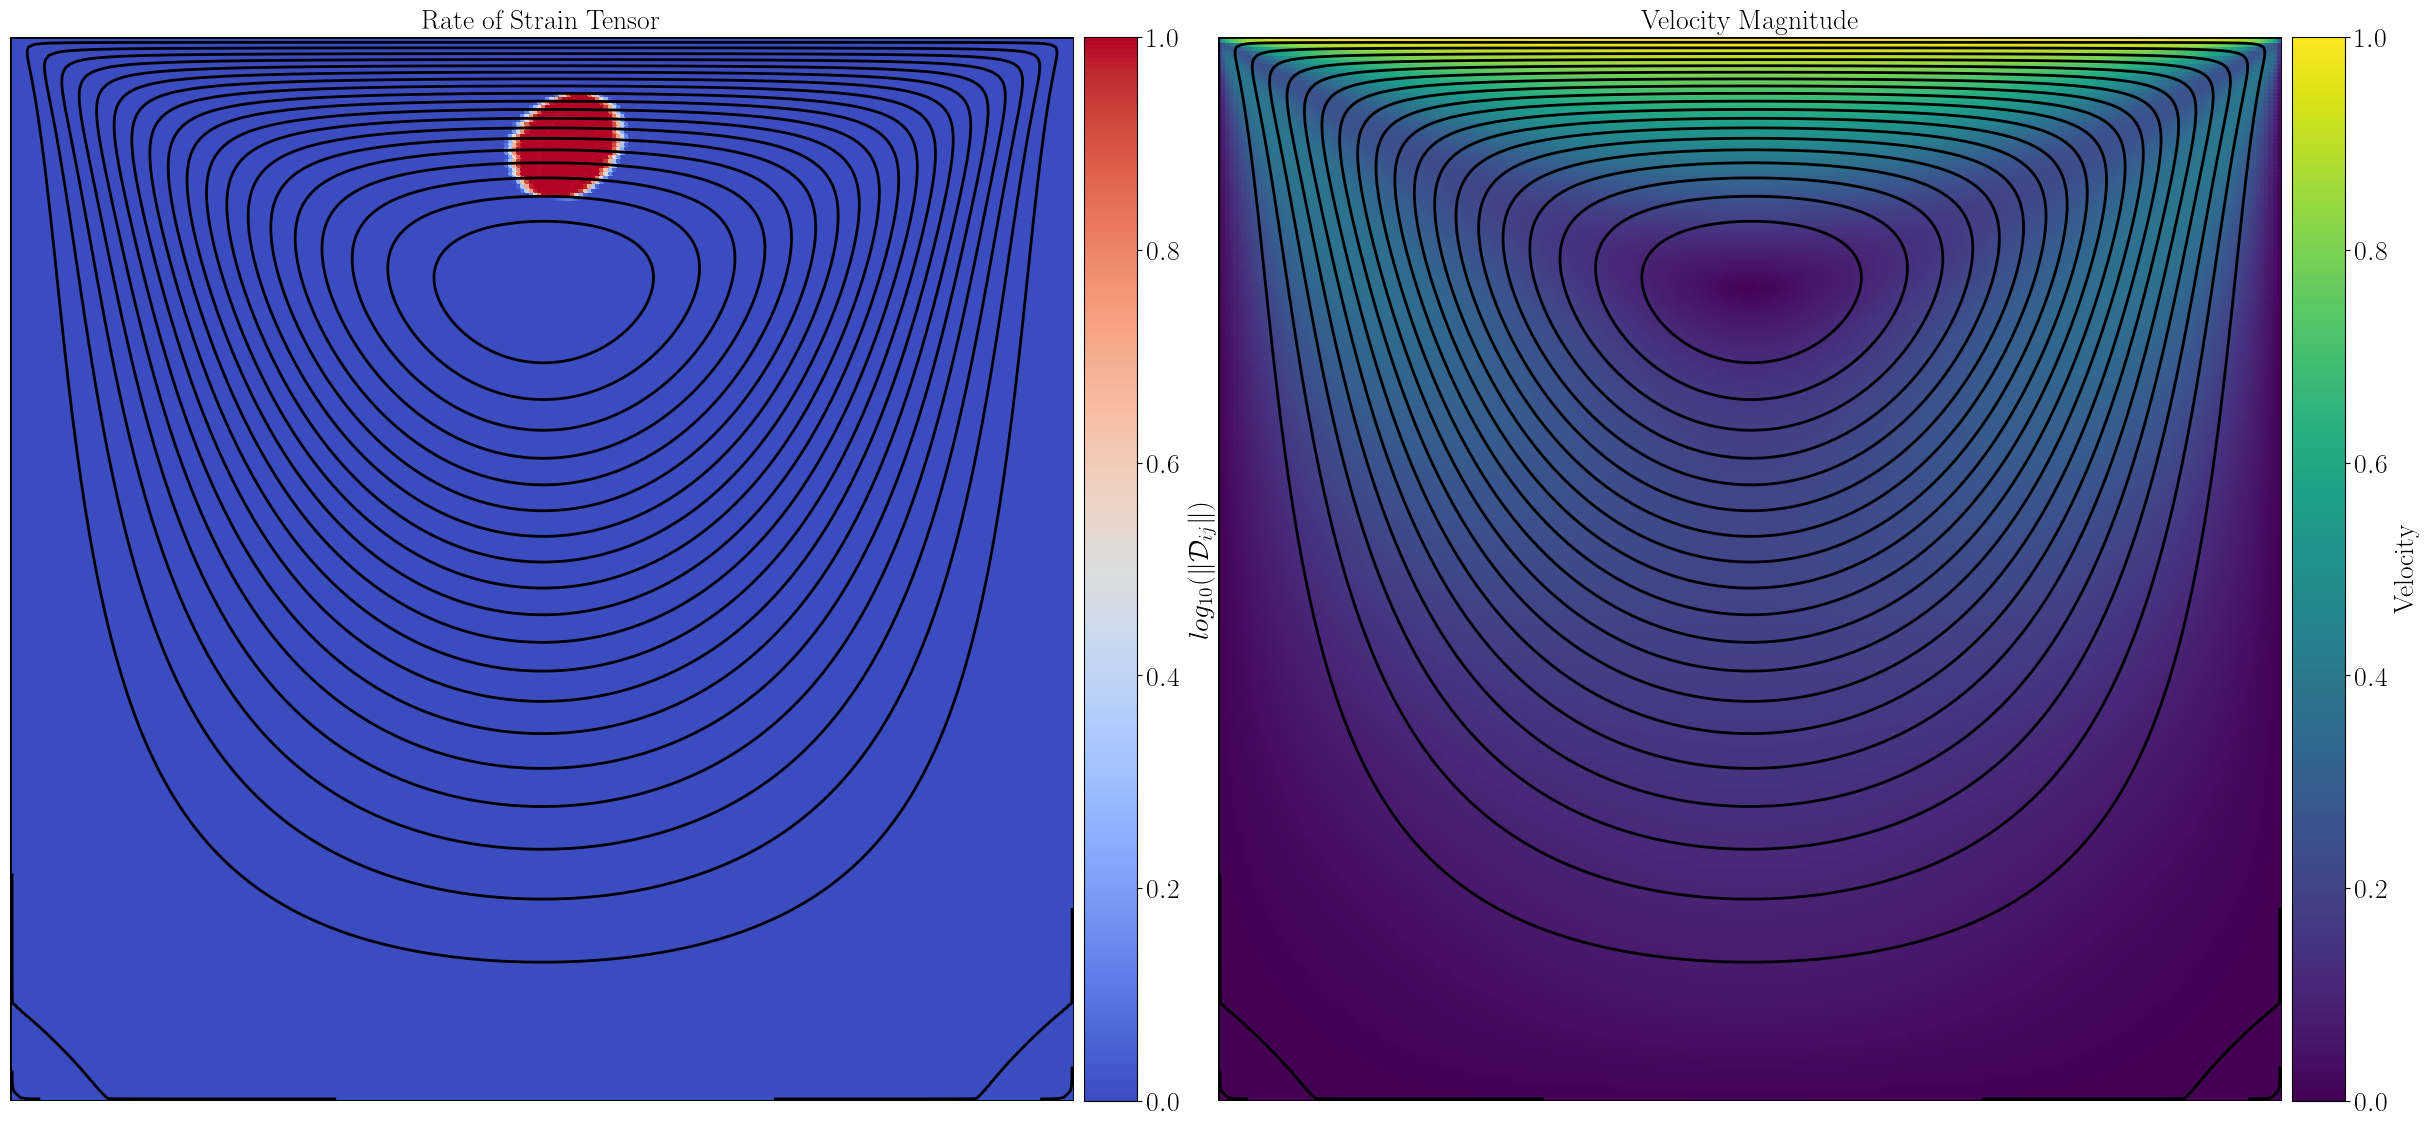

In [4]:
GridsPerR, ZMAX, RMAX, ZMIN, RMIN = 512, 0.5, 0.5, -0.5, -0.5,

caseToProcess, folderToSave = '../simulationCases/LidDrivenCavity-Newtonian-dyeInjection', 'LidDrivenCavity-Newtonian-dyeInjection'

process_timestep(caseToProcess, folderToSave, GridsPerR, RMIN, RMAX, ZMIN, ZMAX, lw=2, t = 0.1)